## Importing libraries

In [34]:
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, Image, DatasetDict
from transformers import (
    ViTForImageClassification, 
    ViTImageProcessor,
    BeitForImageClassification,
    BeitImageProcessor,
    MobileViTForImageClassification,
    MobileViTImageProcessor
)
from torchvision.transforms import (
    Normalize,
    ToTensor,
    Resize,
    CenterCrop,
    Compose,
)
import torch
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer
from dotenv import load_dotenv
import wandb
import evaluate
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
wandb.login(key=os.environ["wandb_api_key"])
os.environ["WANDB_PROJECT"]="Classification-BR-VIT"
os.environ["WANDB_LOG_MODEL"]="end"
os.environ["WANDB_WATCH"]="false"

wandb: Currently logged in as: urbankacper613 (urbankacper613-politechnika-rzeszowska-im-i-ukasiewicza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\urbii\_netrc


## Preparing data
For further part I want to get some information about data, like filepath, label id, time_of_day and season. In latter part I will conduct experiments like make training on some part and excluded images taken during day and test on it. Thanks to this information I will have much easier later.

In [52]:
list_of_files = os.listdir("data/images")

In [53]:
dict_of_files = {key: list_of_files[i: i+60] for key, i in enumerate(range(0, len(list_of_files), 60))}

In [54]:
dict_of_data = {"filepath" : [], "label_ids" : [], "time_of_day": [], "season": []}
additional_labels = [("day", "autumn"), ("night", "autumn"), ("day", "winter"), ("night", "winter"), ("day", "spring"), ("night", "spring")]
for key in dict_of_files.keys():
    for i in range(len(dict_of_files[key])):
        dict_of_data["filepath"].append(dict_of_files[key][i])
        dict_of_data["label_ids"].append(key)
        dict_of_data["time_of_day"].append(additional_labels[i//10][0])
        dict_of_data["season"].append(additional_labels[i//10][1])
br_df = pd.DataFrame(dict_of_data)
br_df.head(5)

,filepath,label_ids,time_of_day,season
0,00_00_00.jpg,0,day,autumn
1,00_00_01.jpg,0,day,autumn
2,00_00_02.jpg,0,day,autumn
3,00_00_03.jpg,0,day,autumn
4,00_00_04.jpg,0,day,autumn


In [55]:
br_df.tail(5)

,filepath,label_ids,time_of_day,season
2995,49_05_05.jpg,49,night,spring
2996,49_05_06.jpg,49,night,spring
2997,49_05_07.jpg,49,night,spring
2998,49_05_08.jpg,49,night,spring
2999,49_05_09.jpg,49,night,spring


In [56]:
ids_split_data = {}
compose_labels = ["day", "night", "winter", "spring", "autumn", ("day", "winter"), ("night", "winter"), ("day", "spring"), ("night", "spring"),
                    ("day", "autumn"), ("night", "autumn")]
for label in compose_labels:
    if len(label) == 2:
        ids_split_data[f"{label[0]}-{label[1]}"] = br_df.loc[(br_df["time_of_day"] == label[0]) & (br_df["season"] == label[1])].index.tolist()
    else:
        try:
            ids_split_data[label] = br_df[br_df["time_of_day"] == label].index.tolist()
        except:
            ids_split_data[label] = br_df[br_df["season"] == label].index.tolist()

In [57]:
ids = br_df.loc[(br_df["time_of_day"] == "day") & (br_df["season"] == "spring")].index.tolist()

In [58]:
br_df.iloc[ids_split_data["day-autumn"], :]

,filepath,label_ids,time_of_day,season
0,00_00_00.jpg,0,day,autumn
1,00_00_01.jpg,0,day,autumn
2,00_00_02.jpg,0,day,autumn
3,00_00_03.jpg,0,day,autumn
4,00_00_04.jpg,0,day,autumn
...,...,...,...,...
2945,49_00_05.jpg,49,day,autumn
2946,49_00_06.jpg,49,day,autumn
2947,49_00_07.jpg,49,day,autumn
2948,49_00_08.jpg,49,day,autumn


In [59]:
ids_split_data.keys()

dict_keys(['day', 'night', 'winter', 'spring', 'autumn', 'day-winter', 'night-winter', 'day-spring', 'night-spring', 'day-autumn', 'night-autumn'])

In [60]:
br_df["filepath"] = "data/images/" + br_df["filepath"]
br_df.to_csv("data/data_informations.csv", index=False)
with open("data/dictionary_ids.json", "w") as file:
    json.dump(ids_split_data, file)

In [61]:
with open("data/dictionary_ids.json") as file:
    data = json.load(file)

## Load images
I just wanted to show an example image to get more information about it and how i can harness new dataframe to gather appropriate images.

In [11]:
with Image.open(os.path.join("data", "images",br_df["filepath"][0])) as im:
    im.show()

In [12]:
img = Image.open(os.path.join("data", "images",br_df["filepath"][0]))

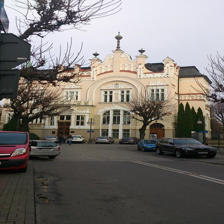

In [13]:
transformed = img.resize((224, 224))
transformed

## Prepare dataset
I created a function which prepare appropriate transfomers dataset. I will experiment on different part of dataset so it is really convient.

In [2]:
with open("data/dictionary_ids.json") as file:
    data = json.load(file)

In [3]:
df_information = pd.read_csv("data/data_informations.csv")
df_information

,filepath,label_ids,time_of_day,season
0,data/images/00_00_00.jpg,0,day,autumn
1,data/images/00_00_01.jpg,0,day,autumn
2,data/images/00_00_02.jpg,0,day,autumn
3,data/images/00_00_03.jpg,0,day,autumn
4,data/images/00_00_04.jpg,0,day,autumn
...,...,...,...,...
2995,data/images/49_05_05.jpg,49,night,spring
2996,data/images/49_05_06.jpg,49,night,spring
2997,data/images/49_05_07.jpg,49,night,spring
2998,data/images/49_05_08.jpg,49,night,spring


In [4]:
ids = data['day']
len(df_information.iloc[ids, 1].to_list())

1500

In [5]:
def create_dataset(test_ids: list[int], df: pd.DataFrame) -> tuple[DatasetDict, Dataset]:
    test_ids_set = set(test_ids)
    all_indices = set(df.index)
    train_ids = list(all_indices - test_ids_set)
    
    train_dataset = Dataset.from_dict({
        "image": df.iloc[train_ids, 0].to_list(),
        "label": df.iloc[train_ids, 1].to_list()
    }).cast_column("image", Image())


    train_val_dataset = train_dataset.class_encode_column("label").train_test_split(test_size=0.1, seed=42, stratify_by_column='label')
    test_dataset = Dataset.from_dict({
        "image": df.iloc[test_ids, 0].to_list(),
        "label": df.iloc[test_ids, 1].to_list()
    }).cast_column("image", Image())

    return train_val_dataset, test_dataset

def apply_transforms(examples):
    examples["pixel_values"] = [dataset_transform(image.convert("RGB")) for image in examples["image"]]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [6]:
processor = ViTImageProcessor("models/google/processor")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

dataset_transform = Compose([
    Resize(size),
    CenterCrop((size, size)),
    ToTensor(),
    normalize,
])

In [7]:
train_val_dataset, test_dataset = create_dataset(ids, df_information)

Casting to class labels: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 249700.59 examples/s]


In [8]:
train_dataset, val_dataset = train_val_dataset["train"], train_val_dataset["test"]

In [9]:
train_dataset.set_transform(apply_transforms)
val_dataset.set_transform(apply_transforms)
test_dataset.set_transform(apply_transforms)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=8)

In [10]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([8])


## Configure model
So in this part I will confiugre trainin arguments for trainer object. Thanks to this we can set an apprioratie batch size etc.

In [11]:
model = ViTForImageClassification.from_pretrained("models/google/model")

In [12]:
model.num_labels

50

In [13]:
train_args = TrainingArguments(
    output_dir="models-info",
    save_strategy="no",
    report_to="wandb",
    logging_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    run_name="google-model-first-try",
    weight_decay=0.01,
    logging_dir="logs",
    remove_unused_columns=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
)

In [14]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

In [15]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)
trainer.train()

C:\Users\urbii\AppData\Local\Temp\ipykernel_27520\3142966030.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.382100,2.546983,0.700000,0.679988
2,1.676400,1.334576,0.960000,0.957762
3,0.632500,0.675766,0.980000,0.979810
4,0.216000,0.385602,0.980000,0.979429
5,0.080900,0.261753,0.986667,0.986286
6,0.040900,0.222024,0.980000,0.979810
7,0.028800,0.204345,0.980000,0.979810
8,0.023400,0.195197,0.980000,0.979810
9,0.020700,0.189770,0.980000,0.979810
10,0.019100,0.188592,0.980000,0.979810


TrainOutput(global_step=850, training_loss=0.6120799392812393, metrics={'train_runtime': 373.4219, 'train_samples_per_second': 36.152, 'train_steps_per_second': 2.276, 'total_flos': 1.046591919249408e+18, 'train_loss': 0.6120799392812393, 'epoch': 10.0})

In [16]:
outputs = trainer.predict(test_dataset)

In [38]:
print(f"Accuracy: {np.round(outputs.metrics['test_accuracy'], 3)}, f1-score: {np.round(outputs.metrics['test_f1'], 3)}")

Accuracy: 0.037, f1-score: 0.034


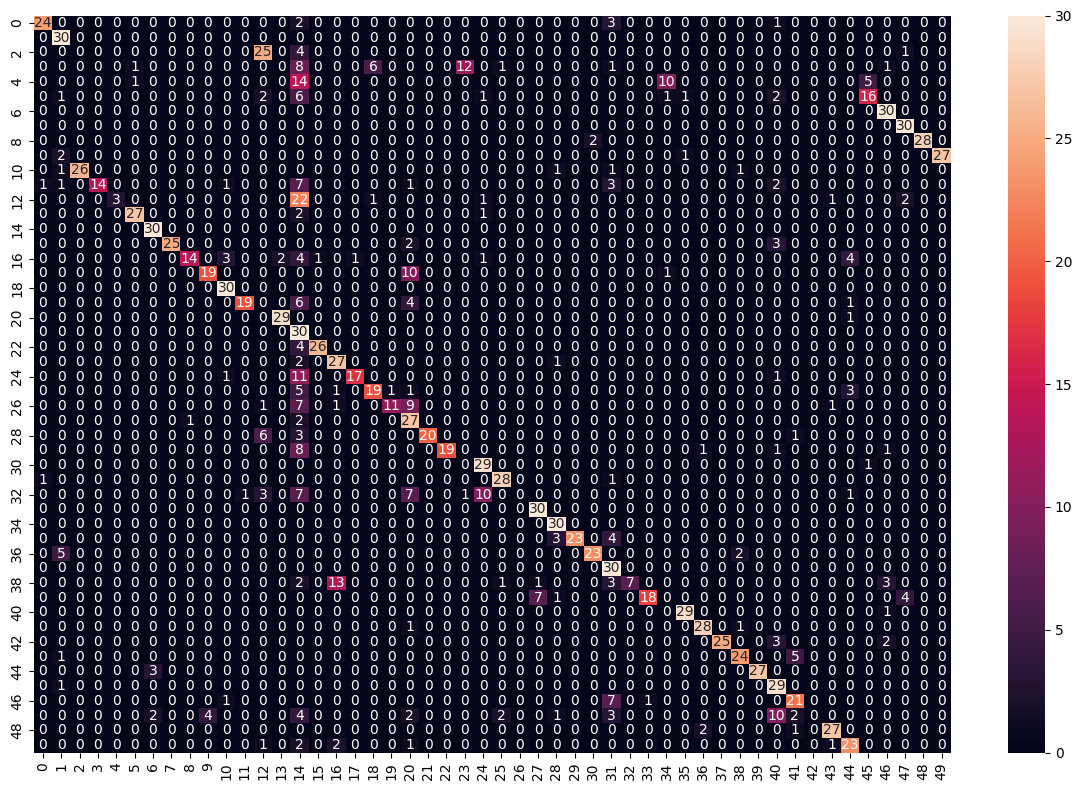

In [77]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, ax=ax, annot=True)
plt.tight_layout()
plt.show()

In [94]:
_ = wandb.finish()

## Experiments

### Helper functions
This functions should prevent redudancy. Also I placed it here, because I want to omit previous code and just start from here.

In [5]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [18]:
def create_dataset(test_ids: list[int], df: pd.DataFrame) -> tuple[DatasetDict, Dataset]:
    test_ids_set = set(test_ids)
    all_indices = set(df.index)
    train_ids = list(all_indices - test_ids_set)
    
    train_dataset = Dataset.from_dict({
        "image": df.iloc[train_ids, 0].to_list(),
        "label": df.iloc[train_ids, 1].to_list()
    }).cast_column("image", Image())


    train_val_dataset = train_dataset.class_encode_column("label").train_test_split(test_size=0.1, seed=42, stratify_by_column='label')
    test_dataset = Dataset.from_dict({
        "image": df.iloc[test_ids, 0].to_list(),
        "label": df.iloc[test_ids, 1].to_list()
    }).cast_column("image", Image())

    return train_val_dataset, test_dataset

def apply_transforms(examples, dataset_transform):
    examples["pixel_values"] = [dataset_transform(image.convert("RGB")) for image in examples["image"]]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [39]:
def prepare_dataset(processor, train_dataset, val_dataset, test_dataset):
    try:
        image_mean, image_std = processor.image_mean, processor.image_std
        size = processor.size["height"]
        
        normalize = Normalize(mean=image_mean, std=image_std)
        
        dataset_transform = Compose([
            Resize(size),
            CenterCrop((size, size)),
            ToTensor(),
            normalize,
        ])
    except:
        size = processor.crop_size["height"]
        
        dataset_transform = Compose([
            Resize(size),
            CenterCrop((size, size)),
            ToTensor(),
        ])
    
    train_dataset.set_transform(lambda examples: apply_transforms(examples, dataset_transform))
    val_dataset.set_transform(lambda examples: apply_transforms(examples, dataset_transform))
    test_dataset.set_transform(lambda examples: apply_transforms(examples, dataset_transform))
    return train_dataset, val_dataset, test_dataset


def train_model(model: ViTForImageClassification | BeitForImageClassification | MobileViTForImageClassification, 
                processor: ViTImageProcessor | BeitImageProcessor | MobileViTImageProcessor, 
                train_dataset: Dataset, val_dataset: Dataset, run_name: str) -> Trainer:
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = logits.argmax(axis=-1)
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
        return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}
        
    train_args = TrainingArguments(
        output_dir="models-info",
        report_to="wandb",
        save_strategy="no",
        logging_strategy="epoch",
        eval_strategy="epoch",
        learning_rate=2e-5,
        num_train_epochs=10,
        run_name=run_name,
        weight_decay=0.01,
        logging_dir="logs",
        remove_unused_columns=False,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
    )

    trainer = Trainer(
        model,
        train_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        tokenizer=processor,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    return trainer

### Testing on day data (excluded from training data)

In [20]:
with open("data/dictionary_ids.json") as file:
    data = json.load(file)

df_information = pd.read_csv("data/data_informations.csv")
ids = data['day']

In [21]:
train_val_dataset, test_dataset = create_dataset(ids, df_information)
train_dataset, val_dataset = train_val_dataset["train"], train_val_dataset["test"]

Casting to class labels: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 234083.27 examples/s]


#### Google ViT

In [22]:
model = ViTForImageClassification.from_pretrained("models/google/model")
processor = ViTImageProcessor.from_pretrained("models/google/processor")

In [23]:
train_dataset_google, val_dataset_google, test_dataset_google = prepare_dataset(processor, train_dataset, val_dataset, test_dataset)

In [24]:
trained_model = train_model(model, processor, train_dataset_google, val_dataset_google, "google-day")

C:\Users\urbii\AppData\Local\Temp\ipykernel_33396\404833092.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.382100,2.546983,0.700000,0.679988
2,1.676400,1.334576,0.960000,0.957762
3,0.632500,0.675766,0.980000,0.979810
4,0.216000,0.385602,0.980000,0.979429
5,0.080900,0.261753,0.986667,0.986286
6,0.040900,0.222024,0.980000,0.979810
7,0.028800,0.204345,0.980000,0.979810
8,0.023400,0.195197,0.980000,0.979810
9,0.020700,0.189770,0.980000,0.979810
10,0.019100,0.188592,0.980000,0.979810


In [25]:
outputs = trained_model.predict(test_dataset_google)
print(f"Accuracy: {np.round(outputs.metrics['test_accuracy'], 3)}, f1-score: {np.round(outputs.metrics['test_f1'], 3)}")

Accuracy: 0.037, f1-score: 0.034


In [ ]:
wandb.finish()

#### Microsoft ViT

In [28]:
model = BeitForImageClassification.from_pretrained("models/microsoft/model")
processor = BeitImageProcessor.from_pretrained("models/microsoft/processor")

In [29]:
train_dataset_microsoft, val_dataset_microsoft, test_dataset_microsoft = prepare_dataset(processor, train_dataset, val_dataset, test_dataset)

In [30]:
trained_model = train_model(model, processor, train_dataset_microsoft, val_dataset_microsoft, "microsoft-day")

C:\Users\urbii\AppData\Local\Temp\ipykernel_33396\404833092.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.765800,1.145009,0.886667,0.877762
2,0.567500,0.244688,0.980000,0.979429
3,0.129000,0.117683,0.993333,0.993143
4,0.043100,0.073345,0.993333,0.993143
5,0.019900,0.073097,0.993333,0.993143
6,0.014500,0.077332,0.993333,0.993143
7,0.007100,0.075293,0.993333,0.993143
8,0.009200,0.078008,0.993333,0.993143
9,0.007800,0.078298,0.993333,0.993143
10,0.006600,0.077412,0.993333,0.993143


In [31]:
outputs = trained_model.predict(test_dataset_microsoft)
print(f"Accuracy: {np.round(outputs.metrics['test_accuracy'], 3)}, f1-score: {np.round(outputs.metrics['test_f1'], 3)}")

Accuracy: 0.037, f1-score: 0.035


In [ ]:
wandb.finish()

#### Apple MobileViT

In [47]:
model = MobileViTForImageClassification.from_pretrained("models/apple/model")
processor = MobileViTImageProcessor.from_pretrained("models/apple/processor")

In [49]:
train_dataset_apple, val_dataset_apple, test_dataset_apple = prepare_dataset(processor, train_dataset, val_dataset, test_dataset)

In [50]:
trained_model = train_model(model, processor, train_dataset_apple, val_dataset_apple, "apple-day")

C:\Users\urbii\AppData\Local\Temp\ipykernel_33396\45990194.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.894500,3.867107,0.046667,0.037698
2,3.840400,3.816084,0.206667,0.178738
3,3.791400,3.761103,0.353333,0.309825
4,3.742500,3.711884,0.460000,0.426241
5,3.692000,3.664858,0.540000,0.500127
6,3.650500,3.616114,0.606667,0.561143
7,3.614100,3.580337,0.600000,0.553794
8,3.586900,3.559011,0.613333,0.569651
9,3.566300,3.539838,0.666667,0.629413
10,3.550900,3.525518,0.653333,0.611032


In [51]:
outputs = trained_model.predict(test_dataset_apple)
print(f"Accuracy: {np.round(outputs.metrics['test_accuracy'], 3)}, f1-score: {np.round(outputs.metrics['test_f1'], 3)}")

Accuracy: 0.026, f1-score: 0.026


In [ ]:
wandb.finish()